# Form Recognition in Spark-OCR fine-tuning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/master/tutorials/Certification_Trainings_JSL/7.1.SparkOcrFormRecognitionFineTuning.ipynb)

### Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
!pip install -q johnsnowlabs

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, visual, medical

# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
nlp.install(refresh_install=True, visual=True)

In [1]:
import pyspark
import json
import os
os.environ["PYSPARK_PYTHON"] = 'python'
os.environ["PYSPARK_PYTHON_DRIVER"] = 'python'

## Start Spark session

In [2]:
from johnsnowlabs import visual, nlp
import pandas as pd

# Automatically load license data and start a session with all jars user has access to
spark = nlp.start(visual=True)


🚨 Your Spark-OCR is outdated, installed==4.3.0 but latest version==4.2.4
You can run  jsl.install() to update Spark-OCR
📋 Loading license number 0 from /home/jose/.johnsnowlabs/licenses/license_number_0_for_Spark-Healthcare_Spark-OCR.json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.2.4, 💊Spark-Healthcare==4.2.4, 🕶Spark-OCR==4.3.0, running on ⚡ PySpark==3.2.1


## Install deps 

In [4]:
!python3.7 -m pip install -U --no-cache-dir gdown --pre

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# downloading and unzipping the dataset
!rm -r ./llmv2_Alab_data
!gdown --id 1eM6xx9GZNypA5IOSOdLTGvF70DI-AtUi
!unzip "2022-05-05-13-38-43_DischargeSummary.zip" -d ./llmv2_Alab_data

# Separating the inference image
!rm -r test
!mkdir test
!mv ./llmv2_Alab_data/images/63-1651494444_0.png ./test/63-1651494444_0.png

/home/jose/.local/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1pG6jbLtxMFH_BLgbljQpmeUIHGzMkobO
To: /home/jose/spark-ocr/workshop/tutorials/Certification_Trainings_JSL/2022-05-05-13-38-43_DischargeSummary.zip
100%|██████████████████████████████████████| 56.7M/56.7M [00:01<00:00, 34.1MB/s]
Archive:  2022-05-05-13-38-43_DischargeSummary.zip
   creating: ./llmv2_Alab_data/images/
  inflating: ./llmv2_Alab_data/result.json  
  inflating: ./llmv2_Alab_data/images/100-1651494444_0.png  
  inflating: ./llmv2_Alab_data/images/51-1651494444_0.png  
  inflating: ./llmv2_Alab_data/images/34-1651494444_0.png  
  inflating: ./llmv2_Alab_data/images/75-1651494444_1.png  
  inflating: ./llmv2_Alab_data/images/62-1651494444_1.png  
  inflating: ./llmv2_Alab_data/images/18-1651494444_0

  inflating: ./llmv2_Alab_data/images/16-1651494444_1.png  
  inflating: ./llmv2_Alab_data/images/48-1651494444_1.png  
  inflating: ./llmv2_Alab_data/images/54-1651494444_1.png  
  inflating: ./llmv2_Alab_data/images/32-1651494444_0.png  
  inflating: ./llmv2_Alab_data/images/22-1651494444_1.png  
  inflating: ./llmv2_Alab_data/images/98-1651494444_1.png  
  inflating: ./llmv2_Alab_data/images/13-1651494444_0.png  
  inflating: ./llmv2_Alab_data/images/7-1651494444_0.png  
  inflating: ./llmv2_Alab_data/images/41-1651494444_2.png  
  inflating: ./llmv2_Alab_data/images/14-1651494444_0.png  
  inflating: ./llmv2_Alab_data/images/15-1651494444_1.png  
  inflating: ./llmv2_Alab_data/images/63-1651494444_1.png  
  inflating: ./llmv2_Alab_data/images/30-1651494444_0.png  
  inflating: ./llmv2_Alab_data/images/18-1651494444_1.png  
  inflating: ./llmv2_Alab_data/images/7-1651494444_1.png  
  inflating: ./llmv2_Alab_data/images/66-1651494444_1.png  
  inflating: ./llmv2_Alab_data/images/26-1

In [10]:
## Installing Dependencies
!python3.7 -m pip install torch==1.8
!python3.7 -m pip install --upgrade git+https://github.com/JohnSnowLabs/detectron2.git@frozen_sparkocr
!python3.7 -m pip install --upgrade git+https://github.com/JohnSnowLabs/transformers.git@layoutlmv2_onnx

!python3.7 -m pip install pyyaml
!python3.7 -m pip install datasets==1.18.2

Defaulting to user installation because normal site-packages is not writeable
  Using cached torch-1.8.0-cp37-cp37m-manylinux1_x86_64.whl (735.5 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.8.1+cu110 requires torch==1.7.0, but you have torch 1.8.0 which is incompatible.
optimum 1.5.1 requires torch>=1.9, but you have torch 1.8.0 which is incompatible.
You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/JohnSnowLabs/detectron2.git (to revision frozen_sparkocr) to /tmp/pip-req-build-ob4zt1l8
  Running command git clone --filter=blob:none --quiet ht

You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/JohnSnowLabs/transformers.git (to revision layoutlmv2_onnx) to /tmp/pip-req-build-q_7ba_p7
  Running command git clone --filter=blob:none --quiet https://github.com/JohnSnowLabs/transformers.git /tmp/pip-req-build-q_7ba_p7
  Running command git checkout -b layoutlmv2_onnx --track origin/layoutlmv2_onnx
  Switched to a new branch 'layoutlmv2_onnx'
  Branch 'layoutlmv2_onnx' set up to track remote branch 'layoutlmv2_onnx' from 'origin'.
  Resolved https://github.com/JohnSnowLabs/transformers.git to commit cb2e4aaf8d1f23e944fdb62fb6d57042dee0d27d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.
Defaulting to 

You should consider upgrading via the '/usr/bin/python3.7 -m pip install --upgrade pip' command.


## Note: 
you should restart the runtime at this point and continue below

## Read image with form

In [3]:
%%time
from sparkocr.transformers.readers.alab_readers import AlabReaders

pyspark_dataframe = AlabReaders().dataLabeler(spark,
                                              "./llmv2_Alab_data/result.json",
                                              "./llmv2_Alab_data/images"
                                              ).cache()


CPU times: user 240 ms, sys: 43.3 ms, total: 283 ms
Wall time: 3.69 s


## Define pipeline for predict

In [4]:
from pyspark.ml import PipelineModel
from sparkocr.enums import *
from sparkocr.transformers import *
from sparkocr.transformers.ner import *
from sparkocr.transformers.tokenizer.hocr_tokenizer import HocrTokenizer
from sparkocr.utils import display_images_horizontal


binary_to_image = BinaryToImage() \
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

img_to_hocr = ImageToHocr() \
    .setInputCol("image") \
    .setOutputCol("hocr") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"])

tokenizer = HocrTokenizer() \
    .setInputCol("hocr") \
    .setOutputCol("token")


## Define VisualDocumentNerV21 for finetuning

* load model
* difine params of training

In [5]:
doc_ner_fine_tuned = VisualDocumentNerV21()\
            .loadHuggingFaceModel("nielsr/layoutlmv2-finetuned-funsd", spark) \
            .setInputCols(["token", "image"]) \
            .setOutputCol("entities") \
            .setWhiteList( ['Diagnosis-B',
                            'Diagnosis-I',
                            'Drug-B',
                            'Drug-I',
                            'Symptom-B',
                            'Symptom-I',
                            'others'])\
            .setLabels(['Diagnosis-B',
                            'Diagnosis-I',
                            'Drug-B',
                            'Drug-I',
                            'Symptom-B',
                            'Symptom-I',
                            'others'])\
            .setbatchSize(4) \
            .setShuffleBatchTraining(True) \
            .setnumTrainEpochs(15)\
            .setImageSize(224)

### Pre-Training Inference

In [6]:
draw_annotations = ImageDrawAnnotations() \
            .setInputCol("image") \
            .setInputChunksCol("entities") \
            .setOutputCol("image_with_annotations") \
            .setFilledRect(False) \
            .setFontSize(14) \
            .setRectColor(Color.red) #\
            # .setColorMap(
            # {"other": Color.pink, "b-header": Color.yellow, "i-header": Color.yellow, "b-question": Color.blue,
            #  "i-question": Color.blue, "b-answer": Color.green, "i-answer": Color.green})

pipeline_predict = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    tokenizer,
    doc_ner_fine_tuned,
    draw_annotations
])


    Image #0:
    Origin: file:/home/jose/spark-ocr/workshop/tutorials/Certification_Trainings_JSL/test/63-1651494444_0.png
    Resolution: 0 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


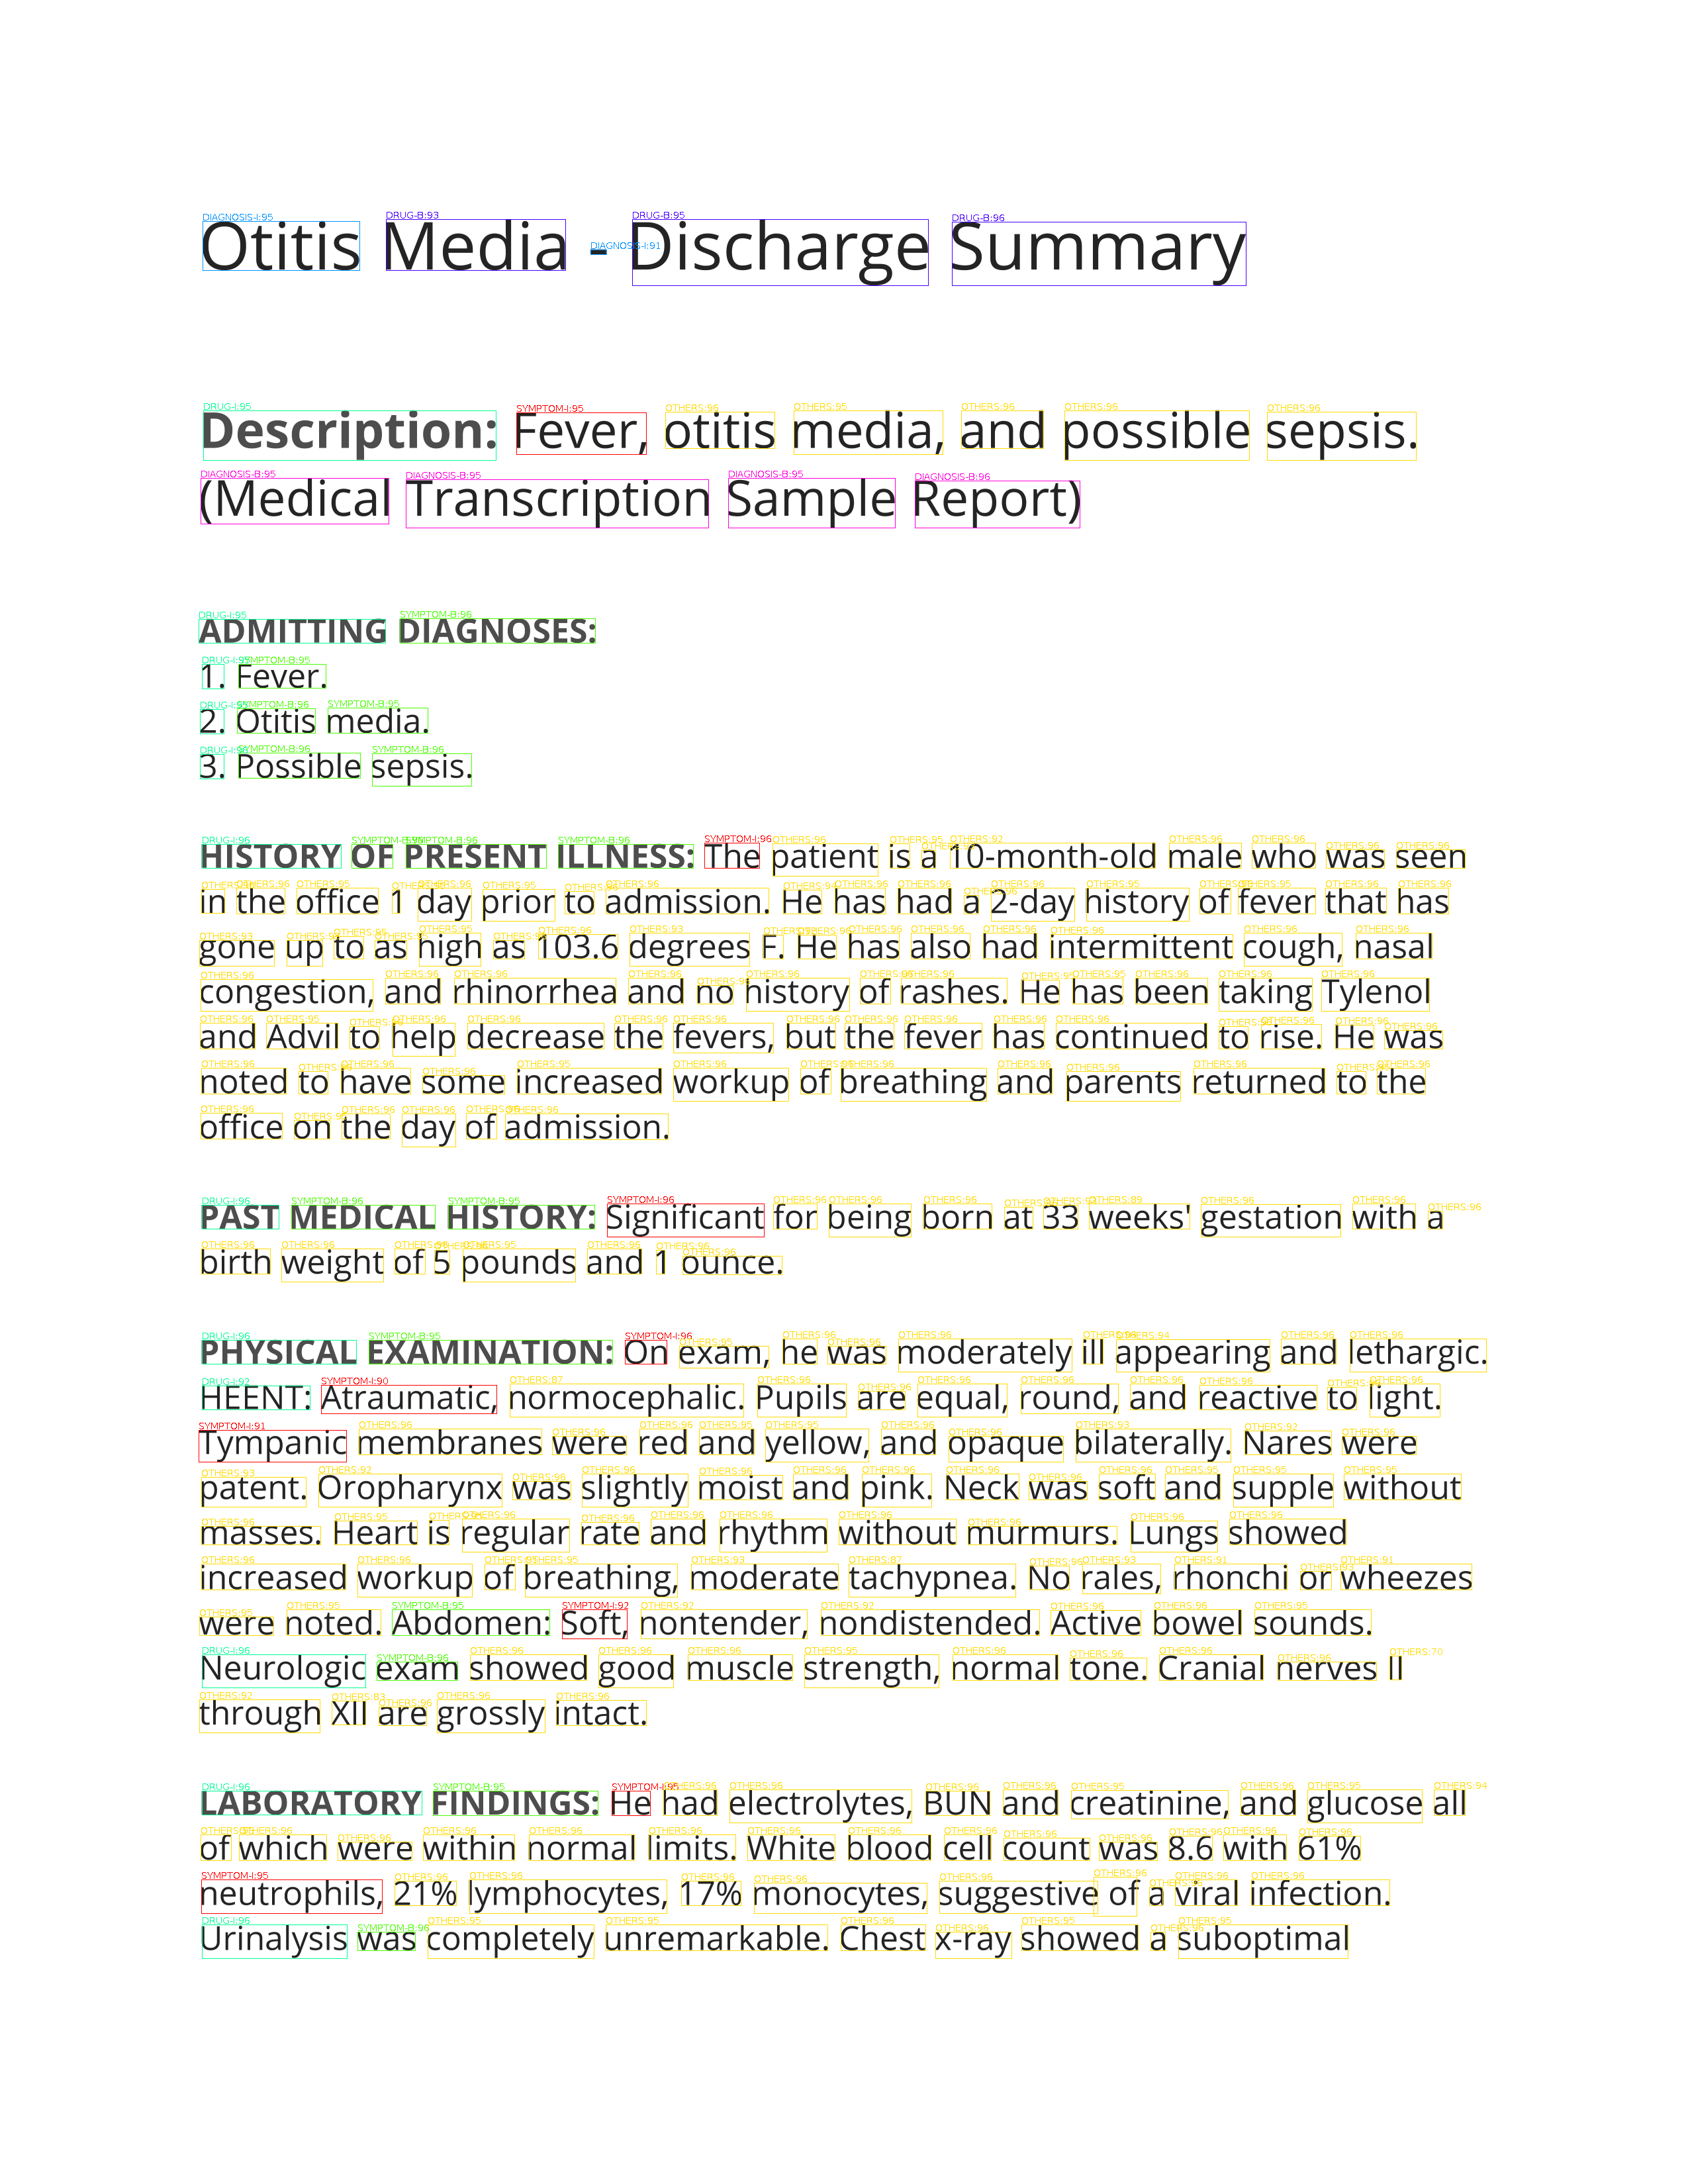

In [7]:
from sparkocr.utils import display_images_horizontal
from sparkocr.utils import display_images
  
bin_df = spark.read.format("binaryFile").load("./test")
results = pipeline_predict.transform(bin_df)

display_images(results, "image_with_annotations")

## Fit the model

In [8]:
%%time
ner_fit_model = doc_ner_fine_tuned.fit(pyspark_dataframe)


RuntimeError: CUDA error: out of memory

## Call finetuned model for predict

In [ ]:
pipeline_predict = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    tokenizer,
    ner_fit_model,
    draw_annotations
])

### Post Training Inference


    Image #0:
    Origin: file:/content/test/63-1651494444_0.png
    Resolution: 0 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


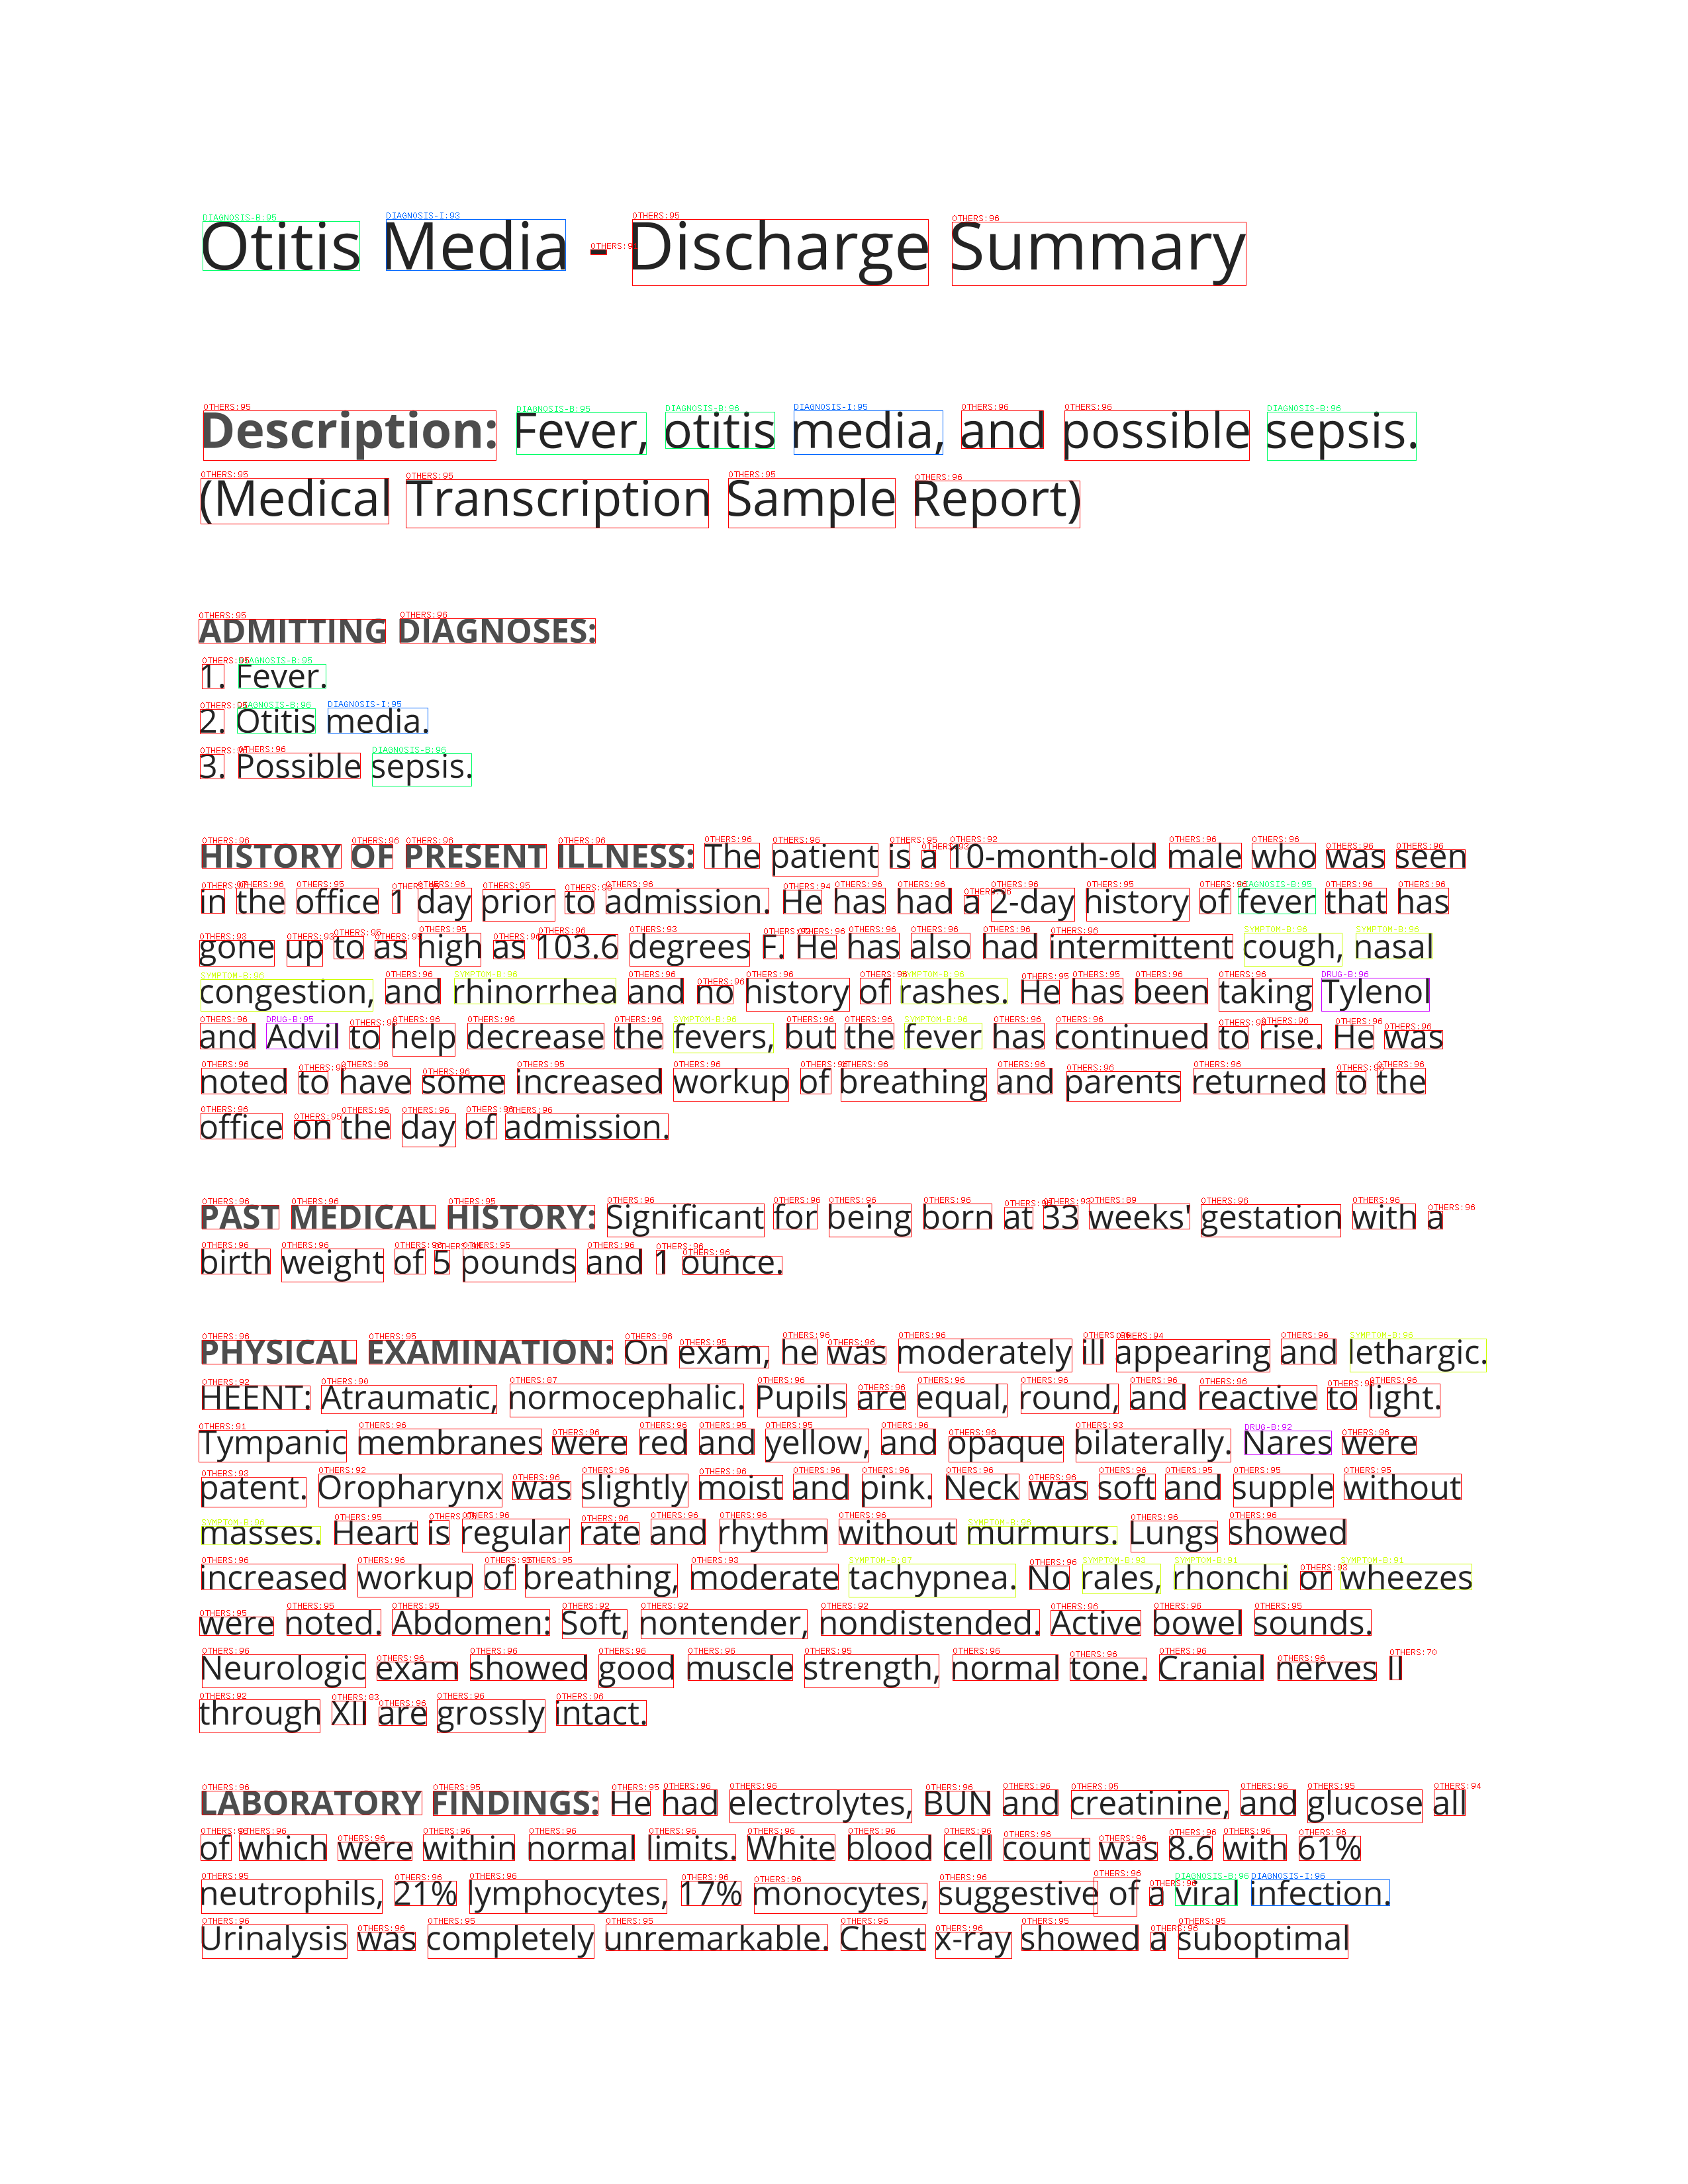

In [ ]:
from sparkocr.utils import display_images_horizontal

from sparkocr.utils import display_images

  
bin_df = spark.read.format("binaryFile").load("/content/test")
bin_df = bin_df
results = pipeline_predict.transform(bin_df)

display_images(results, "image_with_annotations")
